In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Nerf--

In [ ]:
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from scipy.spatial import Delaunay
import torchvision.transforms as transforms
import spacy
import nltk
import math

import os, random, datetime
import matplotlib.pyplot as plt 
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchvision.utils import save_image
from PIL import Image
import PIL
import pickle
from torch.utils.data import Dataset
from glob import glob
import time
import gc
import imageio
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install open3d
# import open3d as o3d
import os
import glob
 
!pip install pyprind
import pyprind
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from google.colab import files

In [ ]:
!git clone https://github.com/ActiveVisionLab/nerfmm.git
from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4

In [4]:
batch_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
H = 756
W = 1008

## Loading the Data

In [ ]:
# get prepared example scenes
!wget https://www.robots.ox.ac.uk/~ryan/nerfmm2021/nerfmm_colab_data.tar.gz

# extract and clean storage
!tar xzf nerfmm_colab_data.tar.gz
!rm nerfmm_colab_data.tar.gz

Loaded 26 imgs, resolution 756 x 1008
torch.Size([26, 756, 1008, 3])


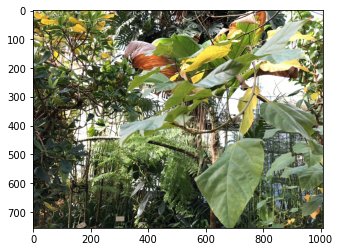

In [6]:
image_dir = os.path.join('nerfmm_colab_data', 'llff_leaves')
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs(image_dir)
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
plt.imshow(imgs[0])

## Model

In [7]:
class LearnFocal(nn.Module):
    def __init__(self, H, W, req_grad):
        super(LearnFocal, self).__init__()
        self.H = H
        self.W = W
        self.fx = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )
        self.fy = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )

    def forward(self):
        # order = 2, check our supplementary.
        fxfy = torch.stack([self.fx**2 * self.W, self.fy**2 * self.H])
        return fxfy

def vec2skew(v):
    """
    :param v:  (3, ) torch tensor
    :return:   (3, 3)
    """
    zero = torch.zeros(1, dtype=torch.float32, device=v.device)
    skew_v0 = torch.cat([ zero,    -v[2:3],   v[1:2]])  # (3, 1)
    skew_v1 = torch.cat([ v[2:3],   zero,    -v[0:1]])
    skew_v2 = torch.cat([-v[1:2],   v[0:1],   zero])
    skew_v = torch.stack([skew_v0, skew_v1, skew_v2], dim=0)  # (3, 3)
    return skew_v   # (3, 3)

def Exp(r):
    """so(3) vector to SO(3) matrix
    :param r: (3, ) axis-angle, torch tensor
    :return:  (3, 3)
    """
    skew_r = vec2skew(r)  # (3, 3)
    norm_r = r.norm() + 1e-15
    eye = torch.eye(3, dtype=torch.float32, device=r.device)
    R = eye + (torch.sin(norm_r) / norm_r) * skew_r + ((1 - torch.cos(norm_r)) / norm_r**2) * (skew_r @ skew_r)
    return R


def make_c2w(r, t):
    """
    :param r:  (3, ) axis-angle             torch tensor
    :param t:  (3, ) translation vector     torch tensor
    :return:   (4, 4)
    """
    R = Exp(r)  # (3, 3)
    c2w = torch.cat([R, t.unsqueeze(1)], dim=1)  # (3, 4)
    c2w = convert3x4_4x4(c2w)  # (4, 4)
    return c2w


class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, cam_id):
        r = self.r[cam_id]  # (3, ) axis-angle
        t = self.t[cam_id]  # (3, )
        c2w = make_c2w(r, t)  # (4, 4)
        return c2w

class Nerfmm(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(Nerfmm, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )
        self.layers1 = nn.Sequential(
            nn.Linear(D+pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )
        self.fc_density = nn.Linear(D, 1)
        # self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        x = torch.cat((x, pos_enc), 3)
        
        x = self.layers1(x)
        density = self.fc_density(x)  # (H, W, N_sample, 1)
        # feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([x, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den


focal_net = LearnFocal(H = 756, W = 1008, req_grad=True).to(device)
pose_param_net = LearnPose(num_cams=48, learn_R=True, learn_t=True).to(device)
nerf_model = Nerfmm(63, 27, 128).to(device)

## Training

In [8]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 0.0, 1.0  # ndc near far
      self.N_SAMPLE = 128  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

ray_params = RayParameters()

In [9]:
def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result


def train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                    opt_pose, nerf_model, focal_net, pose_param_net):
    nerf_model.train()
    focal_net.train()
    pose_param_net.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(N_IMGS)
    np.random.shuffle(ids)

    for i in ids:
        fxfy = focal_net()

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        img = imgs[i].to('cuda')  # (H, W, 4)
        c2w = pose_param_net(i)  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_focal.step()
        opt_pose.step()
        opt_nerf.zero_grad()
        opt_focal.zero_grad()
        opt_pose.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

In [10]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

## Actual Training

In [11]:
import tqdm

N_EPOCH = 200  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
# focal_net = LearnFocal(H, W, req_grad=True).cuda()
# pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a tiny NeRF model. Hidden dimension set to 128
# nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Store poses to visualise them later
pose_history = []

# Training

for epoch_i in range(1, N_EPOCH+1):
    L2_loss = train_one_epoch(imgs, H=756, W=1008, ray_params = ray_params, opt_nerf = opt_nerf, opt_focal = opt_focal,
                              opt_pose = opt_pose, nerf_model = nerf_model, focal_net = focal_net, pose_param_net = pose_param_net)
    train_psnr = mse2psnr(L2_loss)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    1 Training PSNR 11.244, estimated fx 1007.0 fy 756.2
epoch    2 Training PSNR 11.860, estimated fx 1013.9 fy 753.8
epoch    3 Training PSNR 11.983, estimated fx 1021.3 fy 768.7
epoch    4 Training PSNR 12.051, estimated fx 1017.0 fy 804.6
epoch    5 Training PSNR 12.268, estimated fx 1025.0 fy 819.7
epoch    6 Training PSNR 12.296, estimated fx 1048.0 fy 841.2
epoch    7 Training PSNR 12.297, estimated fx 1084.8 fy 859.9
epoch    8 Training PSNR 12.504, estimated fx 1094.5 fy 872.9
epoch    9 Training PSNR 12.420, estimated fx 1090.1 fy 894.8
epoch   10 Training PSNR 12.449, estimated fx 1084.6 fy 910.9
epoch   11 Training PSNR 12.490, estimated fx 1066.9 fy 927.1
epoch   12 Training PSNR 12.583, estimated fx 1054.9 fy 958.0
epoch   13 Training PSNR 12.546, estimated fx 1045.2 fy 971.8
epoch   14 Training PSNR 12.617, estimated fx 1041.4 fy 997.4
epoch   15 Training PSNR 12.698, estimated fx 1041.7 fy 1016.5
epoch   16 Training PSNR 12.748, estimated fx 1055.5 fy 1038.8
epoch 

## Step 5: Novel View Synthesis 🖼️

In [12]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from nerfmm.utils.pose_utils import create_spiral_poses
import imageio

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in range(spiral_c2ws.shape[0]):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', 'trex' + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', 'trex' + '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 756 x 1008 for 200 epochs
Rendering novel views in 189 x 252
Novel view rendering done. Saving to GIF images...
GIF images saved.


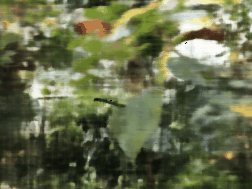

In [13]:
# Image(open(os.path.join('nvs_results', 'trex' + '_img.gif'), 'rb'))
from IPython.display import Image
Image(open('/content/nvs_results/trex_img.gif','rb').read())

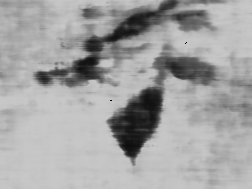

In [14]:
Image(open(os.path.join('nvs_results', 'trex' + '_depth.gif'), 'rb').read())

## Step 6: Visualise Camera Poses 📷

We visualise the optimisation process of camera poses from Z direction, i.e. on 2D XY-plane.

In [15]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
ax0 = plt.subplot(111)
ax0.set_xlim((-0.5, 0.5))            
ax0.set_ylim((-0.5, 0.5))
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.grid(ls='--', color='0.7')

title = ax0.set_title('')
traj_line, = ax0.plot([], [], c='blue', ls='-', marker='^', linewidth=0.7, markersize=4)

def drawframe(fr_id):
    """
    :param fr_id: frame id
    :param poses: (N_img, 3) camera positions
    """
    poses = pose_history[fr_id]
    traj_line.set_data(poses[:, 0], poses[:, 1])
    title.set_text('epoch {0:4d}'.format(fr_id))
    return (traj_line,)

anim = animation.FuncAnimation(fig, drawframe, frames=N_EPOCH, interval=100)

plt.close(anim._fig)
HTML(anim.to_html5_video())